In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2679516928460998863
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5282194241245141131
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1560580085653245502
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11324018607161008800
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

In [ ]:
root = '/content/drive/My Drive/DNAChallenge/'
trainFeatures = root + 'train_values.csv'
trainLabels = root + 'train_labels.csv'
testFeatures = root + 'test_values.csv'
submission = root + 'submission.csv'

In [ ]:
x_train = pd.read_csv(trainFeatures)
y_train = pd.read_csv(trainLabels)

x_test = pd.read_csv(testFeatures)

In [ ]:
x_train = x_train.sample(frac=0.1)
x_train

,sequence_id,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,growth_strain_dh10b,growth_strain_dh5alpha,growth_strain_neb_stable,growth_strain_other,growth_strain_stbl3,growth_strain_top10,growth_strain_xl1_blue,growth_temp_30,growth_temp_37,growth_temp_other,selectable_markers_blasticidin,selectable_markers_his3,selectable_markers_hygromycin,selectable_markers_leu2,selectable_markers_neomycin,selectable_markers_other,selectable_markers_puromycin,selectable_markers_trp1,selectable_markers_ura3,selectable_markers_zeocin,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
35860,UJCYU,CACTCGGTCGCTACGCTCCGGGCGTGAGACTGCGGCGGGCGCTGCG...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30941,2ZU5C,CCGCGGCAGGCCCTCCGAGCGTGGTGGAGCCGTTCTGTGAGACAGC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21534,TP7OZ,ACGTTATCGACTGCACGGTGCACCAATGCTTCTGGCGTCAGGCAGC...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32534,GZR8Z,CCCTCACTCCTTCTCTAGGCGCCGGAATTAGATCTCTCGAGTTGAG...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17208,PH85E,AGAGCTGTACAGTCCGGCCGGACTCAGATCTCGAGCATGGCTGCCC...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17659,XYXDW,TATGTCCTTACAAGATGCTGAATGGTACTGGGGAGATATCTCGAGG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10819,UKZVC,AGACACCGGGACCGATCCAGCCTCCGGGGGATCTTGGTGGCGTGAA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60551,YN84P,CCAGGGTTTTCCCAGTCACGACGTTGTAAAACGACGGCCAGTGAAT...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
26106,ECSBP,GCACTTTTCGGGGAAATGTGCGCGGAACCCCTATTTGTTTATTTTT...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train

,sequence_id,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,0CL7QVG8,0CML4B5I,0DTHTJLJ,0FFBBVE1,0HWCWFNU,0L3Y6ZB2,0M44GDO8,0MDYJM3H,0N3V9P9M,0NP55E93,0PJ91ZT6,0R296F9R,0T2AZBD6,0URA80CN,0VRP2DI6,0W6O08VX,0WHP4PPK,0XPTGGLP,0XS4FHP3,0Y24J5G2,10TEBWK2,11TTDKTM,131RRHBV,13LZE1F7,14PBN8C2,15D0Z97U,15S88O4Q,18C9J8EH,19CAUKJB,1AP294AT,...,Z1C99MVU,Z1Y066QU,Z6LWLWFZ,Z7YFK3I0,Z7ZKDLZG,Z80NVAXF,Z8BWVZZX,ZAYLY2YU,ZB6DPIG5,ZB862XHR,ZBQD50GN,ZC07UYVV,ZCU48L3S,ZEAZQ1QQ,ZEB7PDQK,ZEBTRK7D,ZEJOQQJF,ZELU1VMX,ZFBSIW7Q,ZGY1YZ7P,ZH6LR5MO,ZIGUIE0J,ZIJRW95G,ZK6YBV02,ZLSXM0KN,ZMCRIYYJ,ZMEZU4BS,ZMUIMBDX,ZOI7FJEN,ZQ5A6IY9,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
0,9ZIMC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5SAQC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E7QRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CT5FP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7PTD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,BOQSD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63013,5XVVU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63014,CVGHF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63015,ZVT1A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

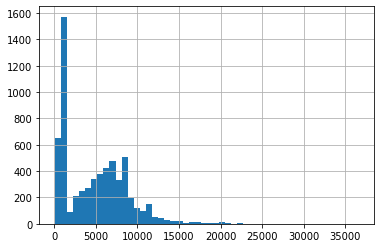

In [ ]:
x_train['sequence'].apply(lambda x: len(list(x))).hist(bins=50)

In [ ]:
maxLength = 500

def getTruncatedPadded(text):
    l = len(text)
    if l > maxLength:
        text = text[:maxLength]
    if l < maxLength:
        text = text + 'N'*(maxLength-l)
    
    return text    

In [ ]:
x_train['sequence'] = x_train['sequence'].apply(lambda x: getTruncatedPadded(x))

In [ ]:
chars = {'A':[1,0,0,0], 'T':[0,1,0,0], 'C':[0,0,1,0], 'G':[0,0,0,1], 'N':[0,0,0,0]}

def oneHotText(text):
    return [chars[x] for x in list(text)]

In [ ]:
X_TRAIN = []

for i , row in x_train.iterrows():
    r = oneHotText(row['sequence'])
    X_TRAIN.append(r)
    
X_TRAIN = np.array(X_TRAIN)

In [ ]:
print(X_TRAIN.shape)

(6302, 500, 4)


In [ ]:
x_train = x_train.set_index('sequence_id').join(y_train.set_index('sequence_id'))

In [ ]:
target = [x for x in y_train.columns if 'sequence' not in x]

In [ ]:
x_train

,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,growth_strain_dh10b,growth_strain_dh5alpha,growth_strain_neb_stable,growth_strain_other,growth_strain_stbl3,growth_strain_top10,growth_strain_xl1_blue,growth_temp_30,growth_temp_37,growth_temp_other,selectable_markers_blasticidin,selectable_markers_his3,selectable_markers_hygromycin,selectable_markers_leu2,selectable_markers_neomycin,selectable_markers_other,selectable_markers_puromycin,selectable_markers_trp1,selectable_markers_ura3,selectable_markers_zeocin,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish,...,Z1C99MVU,Z1Y066QU,Z6LWLWFZ,Z7YFK3I0,Z7ZKDLZG,Z80NVAXF,Z8BWVZZX,ZAYLY2YU,ZB6DPIG5,ZB862XHR,ZBQD50GN,ZC07UYVV,ZCU48L3S,ZEAZQ1QQ,ZEB7PDQK,ZEBTRK7D,ZEJOQQJF,ZELU1VMX,ZFBSIW7Q,ZGY1YZ7P,ZH6LR5MO,ZIGUIE0J,ZIJRW95G,ZK6YBV02,ZLSXM0KN,ZMCRIYYJ,ZMEZU4BS,ZMUIMBDX,ZOI7FJEN,ZQ5A6IY9,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
UJCYU,CACTCGGTCGCTACGCTCCGGGCGTGAGACTGCGGCGGGCGCTGCG...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2ZU5C,CCGCGGCAGGCCCTCCGAGCGTGGTGGAGCCGTTCTGTGAGACAGC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TP7OZ,ACGTTATCGACTGCACGGTGCACCAATGCTTCTGGCGTCAGGCAGC...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GZR8Z,CCCTCACTCCTTCTCTAGGCGCCGGAATTAGATCTCTCGAGTTGAG...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PH85E,AGAGCTGTACAGTCCGGCCGGACTCAGATCTCGAGCATGGCTGCCC...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYXDW,TATGTCCTTACAAGATGCTGAATGGTACTGGGGAGATATCTCGAGG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UKZVC,AGACACCGGGACCGATCCAGCCTCCGGGGGATCTTGGTGGCGTGAA...,1.0,0.0,0.0,0.

In [ ]:
tmpVar = x_train[target].values

IndexError: ignored

In [ ]:
argm = np.argmax(tmpVar, axis=1).tolist()

tmpV = [0] * 1315

sortedArgm = sorted(set(argm))
for x in sortedArgm:
  tmpV[x] = argm.count(x)

maxV = max(tmpV)


d = {}
for x in range(0,1315):
    if tmpV[x] != 0 and x in sortedArgm:
      if tmpV[x] != maxV:
        d[x] = 2*maxV/tmpV[x]
      else:
        print(x, tmpV[x])
        d[x] = 1.0
    else:
      d[x] = 0.0

print(len(d.keys()))
print(d)



666 881
1315
{0: 1762.0, 1: 440.5, 2: 1762.0, 3: 881.0, 4: 58.733333333333334, 5: 1762.0, 6: 1762.0, 7: 881.0, 8: 28.419354838709676, 9: 0.0, 10: 587.3333333333334, 11: 0.0, 12: 30.912280701754387, 13: 1762.0, 14: 0.0, 15: 881.0, 16: 881.0, 17: 293.6666666666667, 18: 881.0, 19: 352.4, 20: 0.0, 21: 587.3333333333334, 22: 1762.0, 23: 881.0, 24: 0.0, 25: 440.5, 26: 352.4, 27: 440.5, 28: 881.0, 29: 440.5, 30: 1762.0, 31: 25.536231884057973, 32: 1762.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 1762.0, 37: 881.0, 38: 881.0, 39: 0.0, 40: 220.25, 41: 0.0, 42: 0.0, 43: 881.0, 44: 0.0, 45: 881.0, 46: 1762.0, 47: 352.4, 48: 195.77777777777777, 49: 0.0, 50: 881.0, 51: 0.0, 52: 0.0, 53: 1762.0, 54: 881.0, 55: 0.0, 56: 881.0, 57: 440.5, 58: 587.3333333333334, 59: 29.366666666666667, 60: 0.0, 61: 881.0, 62: 881.0, 63: 160.1818181818182, 64: 1762.0, 65: 0.0, 66: 0.0, 67: 1762.0, 68: 587.3333333333334, 69: 1762.0, 70: 1762.0, 71: 220.25, 72: 881.0, 73: 440.5, 74: 0.0, 75: 1762.0, 76: 1762.0, 77: 440.5, 78: 1762.

In [ ]:
valsx = [int(x) for x in d.keys() if x != 666]
tmpV.remove(881)

1314
1314


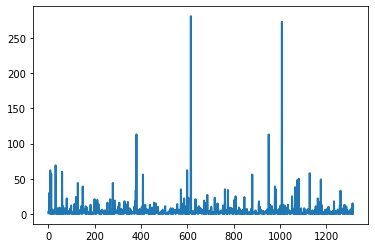

In [ ]:
import matplotlib.pyplot as plt
plt.plot(valsx, tmpV, linewidth=2.0)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_TRAIN, 
                                                    x_train[target].values, 
                                                    test_size = 0.5, 
                                                    random_state=42)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3151, 500, 4)
(3151, 1314)
(3151, 500, 4)
(3151, 1314)


In [ ]:
print(sum(x_train[0]))
print(sum(x_test[0]))
print(y_train[0])
print(y_test[0])

[109 106 133 152]
[126 133 132 109]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(500,4)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=16, kernel_size=7, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=16, kernel_size=9, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1314, activation='softmax'),
])

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 498, 8)            104       
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 249, 8)            0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 243, 16)           912       
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 121, 16)           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 113, 16)           2320      
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 56, 16)            0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 48, 32)          

In [ ]:
!pip install keras-lr-finder

Epoch 1/5
7/7 [==============================] - 0s 14ms/step - loss: 7.1780 - accuracy: 0.0000e+00
Epoch 2/5
7/7 [==============================] - 0s 14ms/step - loss: 7.1530 - accuracy: 0.0146
Epoch 3/5
7/7 [==============================] - 0s 12ms/step - loss: 6.5439 - accuracy: 0.1241
Epoch 4/5
7/7 [==============================] - 0s 12ms/step - loss: 6.5372 - accuracy: 0.0327
Epoch 5/5
7/7 [==============================] - 0s 11ms/step - loss: 6.2643 - accuracy: 0.0635


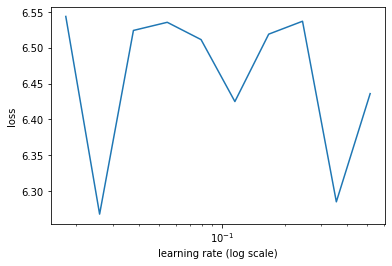

In [ ]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

lr_finder.find(x_train, y_train, start_lr=0.00001, end_lr=1, batch_size=512, epochs=5)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [ ]:
hist = model.fit(x_train, y_train, epochs=500, batch_size=512, validation_data=(x_test, y_test), class_weight=d)

Epoch 1/500
7/7 [==============================] - 0s 52ms/step - loss: 2010.0995 - accuracy: 0.0000e+00 - val_loss: 7.1401 - val_accuracy: 9.5208e-04
Epoch 2/500
7/7 [==============================] - 0s 27ms/step - loss: 1991.7036 - accuracy: 0.0013 - val_loss: 6.9158 - val_accuracy: 9.5208e-04
Epoch 3/500
7/7 [==============================] - 0s 26ms/step - loss: 1931.5942 - accuracy: 0.0019 - val_loss: 7.0224 - val_accuracy: 0.0000e+00
Epoch 4/500
7/7 [==============================] - 0s 24ms/step - loss: 1885.6555 - accuracy: 0.0016 - val_loss: 7.1994 - val_accuracy: 0.0000e+00
Epoch 5/500
7/7 [==============================] - 0s 22ms/step - loss: 1867.4977 - accuracy: 6.3472e-04 - val_loss: 7.5148 - val_accuracy: 0.0000e+00
Epoch 6/500
7/7 [==============================] - 0s 22ms/step - loss: 1858.5638 - accuracy: 9.5208e-04 - val_loss: 7.3825 - val_accuracy: 0.0000e+00
Epoch 7/500
7/7 [==============================] - 0s 22ms/step - loss: 1854.8972 - accuracy: 0.0013 - val

KeyboardInterrupt: ignored

In [ ]:
#### helper plot function
def plot_acc_loss(history):
  plt.plot(history.history['accuracy'], label='acc')
  plt.plot(history.history['val_accuracy'], label='val_acc')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()


  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_los')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

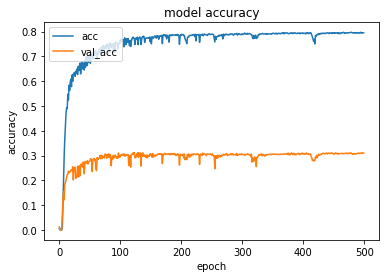

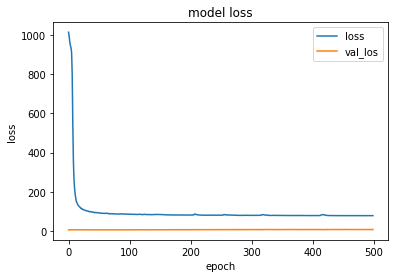

In [ ]:
plot_acc_loss(hist)

In [ ]:
############################ submission phase TODO remove split use all data
submission_data = pd.read_csv(submission)

In [ ]:
x_test['Tdist'] = x_test['sequence'].map(lambda x: list(x).count('T')/len(x))
x_test['Adist'] = x_test['sequence'].map(lambda x: list(x).count('A')/len(x))
x_test['Cdist'] = x_test['sequence'].map(lambda x: list(x).count('C')/len(x))
x_test['Gdist'] = x_test['sequence'].map(lambda x: list(x).count('G')/len(x))
x_test['Ndist'] = x_test['sequence'].map(lambda x: list(x).count('N')/len(x))

In [ ]:
x_test

In [ ]:
test_cols = [x for x in x_test.columns if 'sequence' not in x]

In [ ]:
x_test[test_cols]

In [ ]:
res = model.predict(x_test[test_cols], batch_size=500)

In [ ]:
tmp = np.argmax(res, axis=1)

In [ ]:
output = np.zeros((len(tmp), tmp.max()+1))
output[np.arange(len(tmp)),tmp] = 1

In [ ]:
print(output.shape)
print(submission_data.loc[:, submission_data.columns != 'sequence_id'].shape)

In [ ]:
submission_data.loc[:, submission_data.columns != 'sequence_id'] = output

In [ ]:
submission_data.to_csv(submission, index=False)

In [ ]:
submission_data